# Spherical K-Means  

Code taken from:  
Dan Stowell and Mark Plumbley (2014), Automatic large-scale classification of bird sounds is strongly improved by unsupervised feature learning  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4106198/ 


In [97]:
#!/usr/bin/env python

# Online spherical Hartigan k-means
# Dan Stowell, Jan 2014

# This file in particular is published under the following open licence:
#######################################################################################
# Copyright (c) 2014, Dan Stowell and Queen Mary University of London
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without modification, are permitted provided
# that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this list of conditions
# and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions
#    and the following disclaimer in the documentation and/or other materials provided with the distribution.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED 
# WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A
# PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED
# TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
# HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
# NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.
#######################################################################################

import numpy as np

class OSKmeans:
    """
    This class implements online Hartigan k-means, except:
     - spherical k-means, i.e. the centroids are constrained to L2-norm of 1
     - centroids are initialised randomly on the sphere
     - a weight-offset is used to ensure that the random inits aren't simply blown away as soon as the first data-point comes in

    Further reading:
     - Appendix B of         http://cseweb.ucsd.edu/~bmcfee/papers/bmcfee_dissertation.pdf
     - Coates et al 2012, Learning feature representations with k-means
    """

    def __init__(self, k, d, weightoffset=2):
        """
        k = num centroids
        d = num dimensions
        weightoffset: how "reluctant" the centroids are to move at first. set to 0 for traditional initialisation of centroids as random data.
        """
        self.hitcounts =          [weightoffset               for _ in range(k)]     # shape (k)
        self.centroids = np.array([spherical_random_sample(d) for _ in range(k)])    # shape (k, d)
        self.k = k
        self.d = d

    def weightednearest(self, datum):
        "Find the index of the best-matching centroid, using the Hartigan count-weighting scheme in combination with cosine similarity"
        # find the best-matching centroid (note that it's not pure distance, but count-weighted)
        bestindex = 0
        bestval   = np.inf
        bestcosinesim   = 0
        datum = unit_normalise(datum)

        try:
            cosinesims = np.dot(self.centroids, datum.T)  # cosine similarity, shape (k)
            cosinedists = 1. - cosinesims  # converted to a distance for the benefit of the count-weighting
            cosinedists *= [self.hitcounts[which]/float(self.hitcounts[which]+1) for which in range(self.k)]  # Hartigan count-weighting
        except:
            print("Matrix shapes were: centroids %s, datum %s" % (np.shape(self.centroids), np.shape(datum)))
            raise

        bestindex = np.argmin(cosinedists)
        bestcosinesim = float(cosinesims[bestindex])
        return (bestindex, bestcosinesim)  # NOTE: the dot product returned here is with the normalised input, i.e. with its unit vector.

    def update(self, datum):
        "Feed individual data into this to perform learning"
        datum = np.array(datum)
        bestindex, dotprod = self.weightednearest(datum)

        # update the centroid, including the renormalisation for sphericalness
        centroid = self.centroids[bestindex]
        hitcount = self.hitcounts[bestindex]
        newcentroid = unit_normalise(centroid * hitcount + datum * dotprod)
        self.centroids[bestindex] = newcentroid

        # update the hit count
        self.hitcounts[bestindex] = hitcount + 1
        # return the index, and the amount by which the centroid has changed (useful for monitoring)
        return (bestindex, np.sqrt(((centroid-newcentroid)**2).sum()))

    def train_batch(self, whitedata, niters=10, verbose=True):
        "If you have a batch of data, rather than streamed, this method is a convenience to train using 'niters' iterations of the shuffled data."
        shuffle_indices = np.arange(len(whitedata))
        for whichiter in range(niters):
            if verbose:
                print (f"Iteration {whichiter}")
            np.random.shuffle(shuffle_indices)
            for upindex, index in enumerate(shuffle_indices):
                self.update(whitedata[index])

    def sort_centroids(self):
        """Not needed! Purely cosmetic, for comprehensibility of certain plots. Reorders the centroids by an arbitrary spectral-centroid-like measure.
        Note that for 2D features such as chrmfull, the ordering may not have obvious sense since it operates on the vectorised data."""
        if False:
            binlist = np.arange(len(self.centroids[0]))
            sortifier = np.argsort([np.sum(centroid * binlist)/np.sum(centroid) for centroid in self.centroids])
        else:
            # new sorting method, using a simple approximation to TSP to organise the centroids so that close ones are close.
            similarities = np.dot(self.centroids, self.centroids.T)
            #print "sort_centroids() -- similarities is of shape %s" % str(similarities.shape)

            # Now, starting arbitrarily from index 0, we "grow each end" iteratively
            pathends = [[0], [0]]
            worstarcpos = None
            worstarcdot = 1
            availablenodes = range(1, len(similarities))
            whichend = 0
            #print("---------------------------------------------------")
            while len(availablenodes) != 0:
                #print("availablenodes (length %i): %s" % (len(availablenodes), str(availablenodes)))
                whichend = 1 - whichend  # alternate between one and zero
                frm = pathends[whichend][-1]
                # iterate over the nodes that are so-far unused, finding the best one to join on
                bestpos = availablenodes[0]
                bestdot = -1
                for too in availablenodes:
                    curdot = similarities[frm, too]
                    if curdot > bestdot:
                        bestpos = too
                        bestdot = curdot
                # check if this is the worst arc so far made
                if bestdot < worstarcdot:
                    worstarcdot = bestdot
                    worstarcpos = (whichend, len(pathends[whichend]))
                # append this arc
                pathends[whichend].append(bestpos)
                # remove the chosen one from availablenodes
                #print(" bestpos: %i, dot %g" % (bestpos, bestdot))
                availablenodes.remove(bestpos)

            # finally, we need to check the join-the-two-ends arc to see if it's the worst
            curdot = similarities[pathends[0][-1], pathends[1][-1]]
            # we can choose the worst arc found as the place to split the circuit; and create the sortifier
            if curdot < worstarcdot:
                # we will snip the way the paths themselves snipped
                sortifier = pathends[0][::-1] + pathends[1][1:]
            else:
                # we will snip at some location inside one of the lists, and rejoin
                (snipwhich, snipwhere) = worstarcpos
                sortifier = pathends[snipwhich][snipwhere::-1] + pathends[1-snipwhich][1:] + pathends[snipwhich][:snipwhere:-1]
            if sorted(sortifier) != range(len(similarities)):
                print("pathends: %s" % str(pathends))
                raise RuntimeError("sorted(sortifier) != range(len(similarities)): sorted(%s) != range(%s)") % (sortifier, len(similarities))
            #print("Simple TSP method: decided on the following sortifier: %s" % str(sortifier))

        self.centroids = np.array([self.centroids[index] for index in sortifier])
        self.hitcounts =          [self.hitcounts[index] for index in sortifier]


    def relative_entropy_hitcounts(self):
        "The entropy over the centroid hitcounts is a useful measure of how well they are used. Here we normalise it against the ideal uniform entropy"
        h = 0.
        tot = float(np.sum(self.hitcounts))
        for hitcount in self.hitcounts:
            p = hitcount / tot
            h -= p * np.log(p)
        h_unif = np.log(len(self.hitcounts))
        return h / h_unif

    def reconstruct1(self, datum, whichcentroid):
        "Reconstruct an input datum using a single indexed centroid"
        return self.centroids[whichcentroid] * np.dot(self.centroids[whichcentroid], datum)

    def dotproducts(self, data):
        'Used by thresholded_dotproducts(); subclasses may overwrite'
        return np.dot(data, self.centroids.T)

    def thresholded_dotproducts(self, data, threshold=0.0):
        "One possible 'feature' set based on centroids is this, the thresholded dot products. Supply a matrix as one row per datum."
        try:
            return np.maximum(0, self.dotproducts(data) - threshold)
        except:
            print("Matrix shapes were: centroids %s, data %s" % (np.shape(self.centroids), np.shape(data)))
            raise

###############################################
def spherical_random_sample(d):
    vec = np.random.normal(size=d)
    return unit_normalise(vec)

def unit_normalise(vec):
    return vec / np.sqrt((vec ** 2).sum())

###############################################
# useful functions for whitening a dataset

def normalise_and_whiten(data, retain=0.99, bias=1e-8, use_selfnormn=True, min_ndims=1):
    "Use this to prepare a training set before running through OSKMeans"
    mean = np.mean(data, 0)
    normdata = data - mean

    if use_selfnormn:
        for i in range(normdata.shape[0]):
            normdata[i] -= np.mean(normdata[i])

    # this snippet is based on an example by Sander Dieleman
    cov = np.dot(normdata.T, normdata) / normdata.shape[0]
    eigs, eigv = np.linalg.eigh(cov) # docs say the eigenvalues are NOT NECESSARILY ORDERED, but this seems to be the case in practice...
    print (f"computing number of components to retain {retain:.2f} of the variance...")
    normed_eigs = eigs[::-1] / np.sum(eigs) # maximal value first
    eigs_sum = np.cumsum(normed_eigs)
    num_components = max(min_ndims, np.argmax(eigs_sum > retain)) # argmax selects the first index where eigs_sum > retain is true
    print(f"number of components to retain: {num_components} of {len(eigs)}")
    P = eigv.astype('float32') * np.sqrt(1.0/(eigs + bias)) # PCA whitening
    P = P[:, -num_components:] # truncate transformation matrix

    whitedata = np.dot(normdata, P)
    invproj = np.linalg.pinv(P)
    return ({'centre': mean, 'proj': P, 'ncomponents': num_components, 'invproj': invproj, 'use_selfnormn': use_selfnormn}, whitedata)

def prepare_data(data, norminfo):
    "Typically used for new data; you use normalise_and_whiten() on your training data, then this method projects a new set of data rows in the same way"
    normdata = data - norminfo['centre']
    try:
        if norminfo['use_selfnormn']:
            normdata -= np.mean(normdata, 1).reshape(-1,1)
        return np.dot(normdata, norminfo['proj'])
    except:
        print("Matrix shapes were: data %s, norminfo['proj'] %s, np.mean(normdata, 1) %s" % (np.shape(normdata), np.shape(norminfo['proj']), np.shape(np.mean(normdata, 1))))
        raise

def prepare_a_datum(datum, norminfo):
    "Typically used for new data; you use normalise_and_whiten() on your training data, then this method projects a single test datum in the same way"
    return prepare_data(datum.reshape(1, -1), norminfo).flatten()

def unprepare_a_datum(datum, norminfo, uncentre=True):
    "The opposite of prepare_a_datum(). It can't fix selfnormn but otherwise."
    datum = np.dot(datum, norminfo['invproj'])
    if uncentre:
        datum += norminfo['centre']
    return datum

###############################################

        



## Examples from Dan Stowell

Centroids:
[[ 0.94838364  0.31712533]
 [-0.94043724 -0.33996735]
 [-0.77395344 -0.63324251]]
Centroids:
[[ 0.96645028  0.25685378]
 [-0.99946043 -0.03284583]
 [-0.77395344 -0.63324251]]


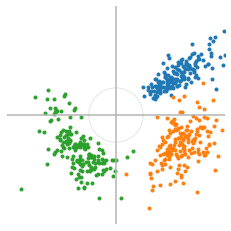

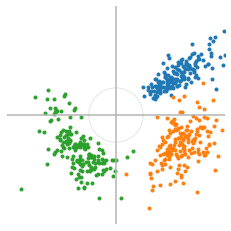

In [ ]:
#@title
if __name__ == "__main__":
    import matplotlib
    # matplotlib.use('PDF') # http://www.astrobetter.com/plotting-to-a-file-in-python/
    import matplotlib.pyplot as plt
    %matplotlib inline

    km = OSKmeans(3, 2)
    print("Centroids:")
    print(km.centroids)
    for _ in range(20):
        km.update([1,0])
        km.update([0,1])
        km.update([-1,0])
    print("Centroids:")
    print(km.centroids)

    ######################################
    # Synthetic example: just for illustration purposes, we will create 3 2D clumps sampled
    # from gaussians on angle and log-magnitude, and learn 10 means

    truecentroids = [ # anglemean, anglesd, logmagmean, logmagsd
        [1.0, 0.1, 1.0, 0.35],
        [2.0, 0.3, 1.0, 0.2],
        [4.0, 0.5, 0.7, 0.2],
    ]
    samples = [[] for _ in truecentroids]
    np.random.seed(12345)
    km = OSKmeans(10, 2)
    for index in range(10000):
        # sample from cluster index % 3
        whichclust = index % len(truecentroids)
        angle = np.random.normal(truecentroids[whichclust][0], truecentroids[whichclust][1])
        magnitude = np.exp(np.random.normal(truecentroids[whichclust][2], truecentroids[whichclust][3]))
        datum = [np.sin(angle) * magnitude, np.cos(angle) * magnitude]
        # store that to the data list, along with its true identity
        if index < 500:
            samples[whichclust].append(datum)
        # run it through kmeans
        km.update(datum)

    for plotlbl, showcentroids in [['datacent', True], ['data', False]]:
        ucircle = plt.Circle((0,0),1, color=[0.9]*3, fill=False)
        ax = plt.gca()
        ax.cla() # clear things for fresh plot
        ax.set_xlim((-4,4))
        ax.set_ylim((-4,4))
        ax.set_aspect('equal', 'box')
        ax.axis('off')
        fig = plt.gcf()
        fig.gca().add_artist(ucircle)
        
        for sampleset in samples:
            plt.plot([datum[0] for datum in sampleset], [datum[1] for datum in sampleset], '.')
        if showcentroids:
            plt.plot([datum[0] for datum in km.centroids], [datum[1] for datum in km.centroids], 'kx')
        plt.xticks([])
        plt.yticks([])
        plt.axvline(0, color=[0.7] * 3)
        plt.axhline(0, color=[0.7] * 3)
        # plt.savefig("%s/oskmeansexample-%s.pdf" % ('.', plotlbl))
        # plt.clf()
        plt.show()

## Bird-song code

In [98]:
import numpy as np
import pandas as pd

import os
import glob

import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm


In [99]:
# For Colab only
# 4/1AY0e-g6CTocvBK45PWlJu2ycBuOMTgu36b-VZgpnCXitW_Vy3ckpGGBzur8
from google.colab import drive
drive.mount('content')
# /content/content/MyDrive/bird-songs/audio

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [100]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs/'
if os.path.isdir(path) == True:
    print('Google Drive Mounted')
    run_on_colab = True
else:
    print('Using local drive')
    run_on_colab = False
    

Google Drive Mounted


In [110]:
if run_on_colab == True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features_filtered.csv', encoding='latin')
else:
    features = pd.read_csv('features_filtered.csv', encoding='latin')
display (features.head())

# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = features[features.en.isin(selected_species)][['id', 'en']]
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.en], axis=1)
dataset.drop('en', axis=1, inplace=True)

display (dataset.head())

,id,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file
0,564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download
1,545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download
2,540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download
3,540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download
4,539275,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,Upper St. Clair Township (near Upper Saint Cl...,"call, song",no score,1:12,yes,//www.xeno-canto.org/539275/download


,id,label
0,564895,3
1,545775,3
2,540857,3
3,540855,3
4,539275,3


In [123]:
def create_mel_spectral_features(sample_rate=22050):
    ''' '''

    mels = []
    audio_filenames = dataset['id'].tolist()

    if run_on_colab == True:
        audio_filenames = list(map(lambda x: '/content/content/MyDrive/bird-songs/audio_8sec/' + str(x) + '.wav',
                              audio_filenames))
    else:
        audio_filenames = list(map(lambda x: '/audio_8sec/' + str(x) + '.wav', audio_filenames))


    for audio_filename in tqdm(audio_filenames[:]): 

        y, sr = librosa.load(audio_filename, sr=sample_rate, mono=True)
        mel = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=20, n_fft=2048, hop_length=1024, fmin=500)
        # print(f"Shape mel spectrogram is {mel.shape}")
        mels.append(mel)
    
    mels = np.array(mels)
    
    if run_on_colab == True:
        outfile = '/content/content/MyDrive/bird-songs/mels_8s_arrays.npy'
    else:
        outfile = './mels_8s_arrays.npy'
    
    with open(outfile, 'wb') as f:
        np.save(f, mels)
    print(mels.shape)
  
    return  None



create_mel_spectral_features()



(2516, 20, 173)


In [125]:
if run_on_colab == True:
    infile = '/content/content/MyDrive/bird-songs/mels_8s_arrays.npy'
else:
    infile = './mels_8s_arrays.npy'

with open(infile, 'rb') as f:
    mels = np.load(f, allow_pickle=False)

print(mels.shape)

mels = mels.reshape(mels.shape[0], -1)
print(mels.shape)
norminfo, whitedata = normalise_and_whiten(mels, retain=0.98, min_ndims=1, use_selfnormn=True)
print (f"Shape normalized and whitened output is {whitedata.shape}")

(2516, 20, 173)
(2516, 3460)
computing number of components to retain 0.98 of the variance...
number of components to retain: 460 of 3460
Shape normalized and whitened output is (2516, 460)


In [127]:

    
print(len(whitedata))
sphericalkm = OSKmeans(500, whitedata.shape[1])
sphericalkm.train_batch(whitedata.tolist(), verbose=True)
    



# print(kmeansobj.centroids)

# print(km_centroids[0].keys(), "\n")
# print(km_centroids[0]['use_selfnormn'])

2516
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [128]:
print(sphericalkm.centroids.shape)

(500, 460)


In [130]:
def transform_newdata(data, norminfo, kmeansobj):
   """This takes input data, whitens it, and projects it into the new
    'feature space' given by proximity to kmeans centroids"""

   whitedata = prepare_data(data, norminfo)
   transformeddata = kmeansobj.thresholded_dotproducts(whitedata)
   del whitedata
   return transformeddata

data = mels
kmeansobj = sphericalkm
newdata = transform_newdata(data, norminfo, kmeansobj)

print(type(newdata))

if run_on_colab == True:
    outfile = '/content/content/MyDrive/bird-songs/spherical_kmeans_features.npy'
else:
    outfile = './spherical_kmeans_features.npy'

with open(outfile, 'wb') as f:
    np.save(f, newdata)
print(newdata.shape)

<class 'numpy.ndarray'>
(2516, 500)


## Scratch Area

In [38]:
((8*22050)/1024) + 1

173.265625

In [ ]:
a = np.array([[1,2,3,4], [4,5,6,7]])
np.mean(a, 0)

array([2.5, 3.5, 4.5, 5.5])